In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
import numpy as np
import matplotlib.pyplot as plt 
import skimage
import rasterio
from sklearn.metrics import accuracy_score
import torch
from sklearn.preprocessing import StandardScaler
import os

In [2]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [25]:
#feature image path
feature_img_path = "Track2/train/images/157.tif"
# Load the feature tif image with multibands
with rasterio.open(feature_img_path) as src:
    feature_img = src.read()
#check if the image is loaded
if feature_img is None:
    print("Error: Image not found")
else:
    print('Feature image size: {}'.format(feature_img.shape))

#load the label image
label_img_path = "Track1/train/labels/157.png"
#load the label image
with rasterio.open(label_img_path) as src:
    label_img = src.read()
#check if the image is loaded
if label_img is None:
    print("Error: Image not found")
else:
    print('Feature image size: {}'.format(label_img.shape))

Feature image size: (12, 128, 128)
Feature image size: (1, 512, 512)


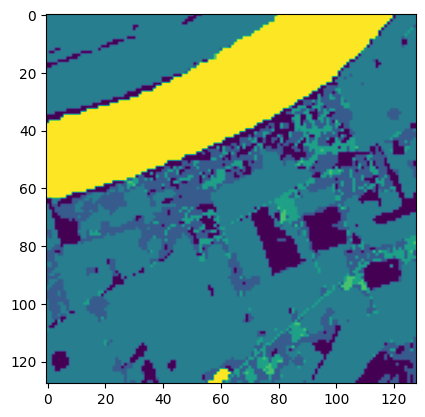

In [26]:
#display the image
plt.imshow(feature_img[10])

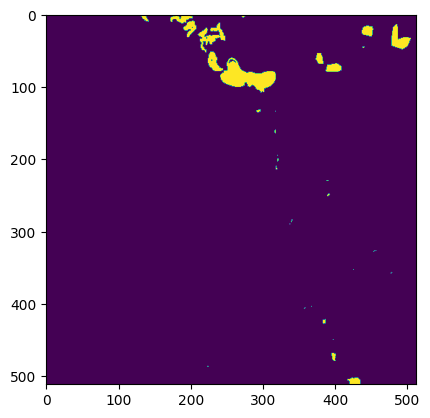

In [27]:
#display the label image
plt.imshow(label_img[0])

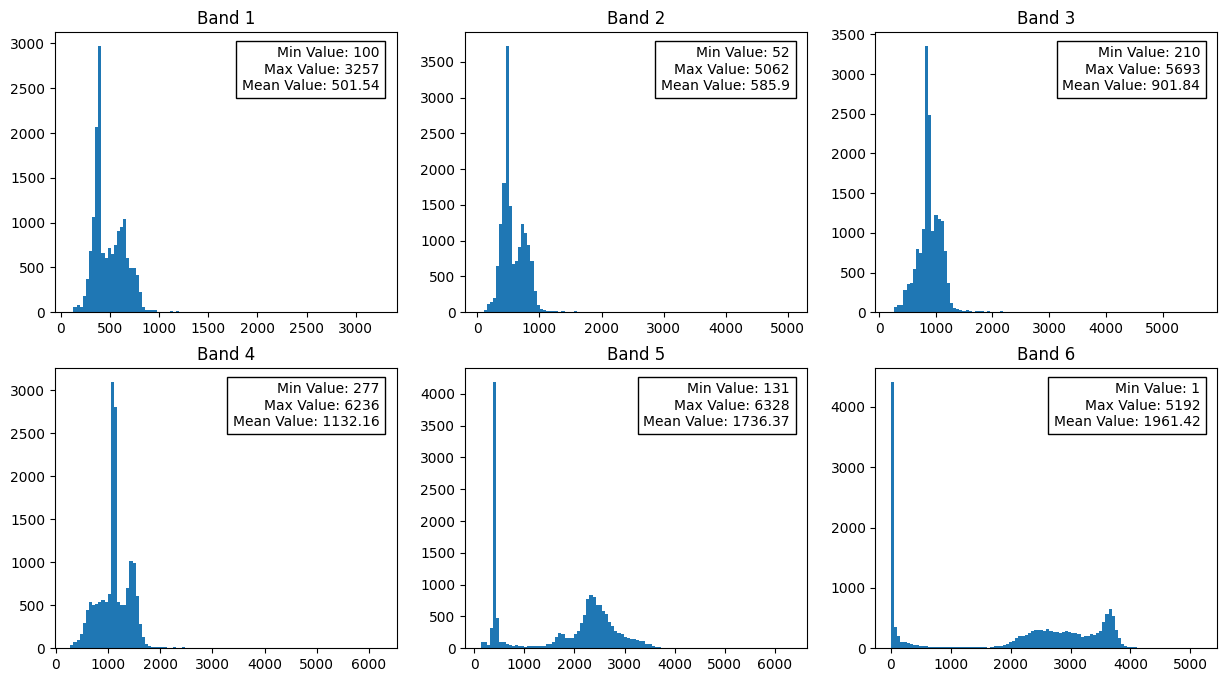

In [30]:
#plot the distribution of the features image.
plt.figure(figsize=(15,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.hist(feature_img[i].ravel(), bins=100)
    plt.title("Band {}".format(i+1))
    plt.text(0.95, 0.95, "Min Value: {}".format(np.min(feature_img[i]))+'\n'+"Max Value: {}".format(np.max(feature_img[i]))+'\n'+"Mean Value: {}".format(round(np.mean(feature_img[i]),2)), ha='right', va='top', transform=plt.gca().transAxes,bbox=dict(facecolor = 'none',edgecolor = 'black'))

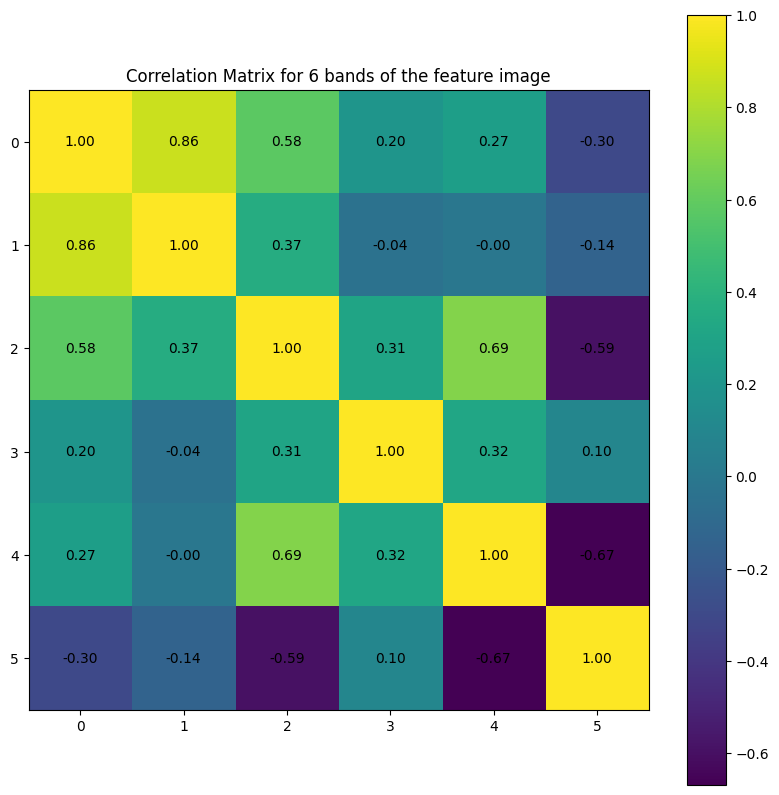

In [31]:
# Calculate the correlation matrix
corr_matrix = np.corrcoef(feature_img.reshape(6, -1), rowvar=True)

# Set up the figure
plt.figure(figsize=(10, 10))

# Display the correlation matrix
cax = plt.imshow(corr_matrix, interpolation='nearest')
plt.colorbar(cax)

# Add title
plt.title("Correlation Matrix for 6 bands of the feature image")

# Adding the correlation values as text annotations
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# Show the plot
plt.show()

Feature image shape: (12, 128, 128) (Bands, Height, Width)


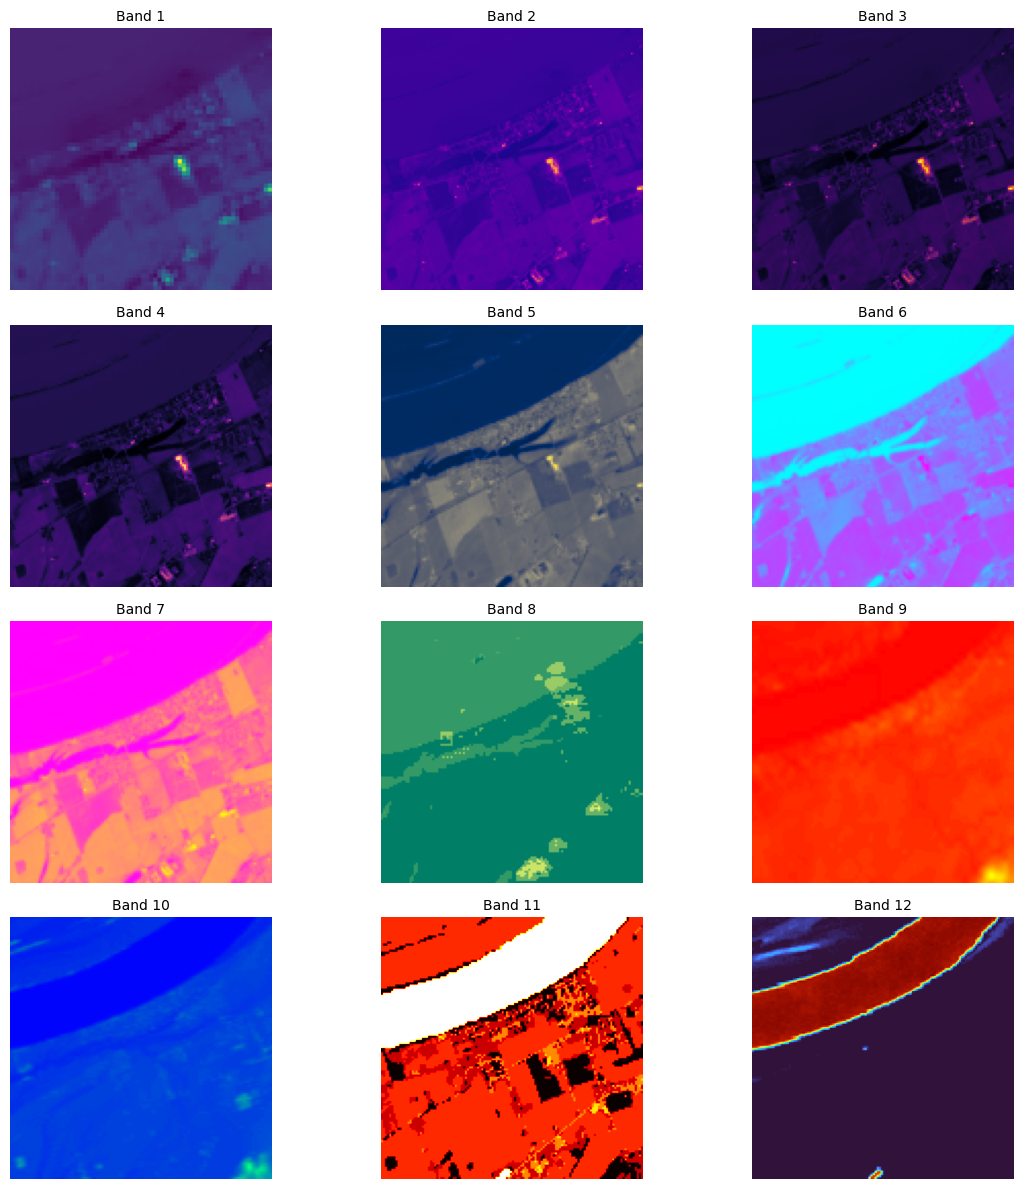

Label image shape: (512, 512) (Height, Width)


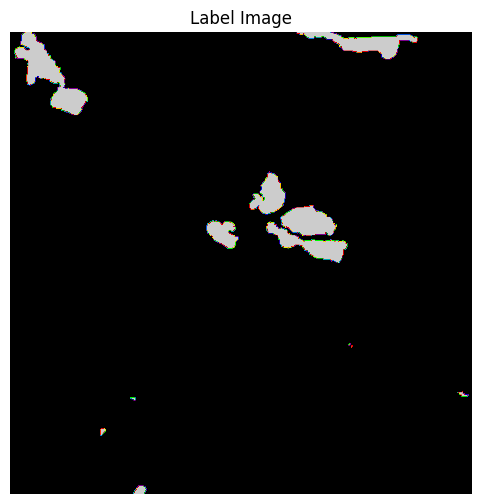

In [35]:
import rasterio
import matplotlib.pyplot as plt

# === Load feature image ===
feature_img_path = "Track2/train/images/157.tif"
with rasterio.open(feature_img_path) as src:
    feature_img = src.read()  # (Bands, H, W)

if feature_img is None:
    print("Error: Feature image not found")
else:
    print(f"Feature image shape: {feature_img.shape} (Bands, Height, Width)")

    # Use different colormaps for visualization
    cmaps = [
        'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'cool',
        'spring', 'summer', 'autumn', 'winter', 'hot', 'turbo'
    ]
    
    num_bands = feature_img.shape[0]
    fig, axes = plt.subplots(nrows=(num_bands + 2) // 3, ncols=3, figsize=(12, 3 * ((num_bands + 2) // 3)))
    axes = axes.flatten()

    for i in range(num_bands):
        axes[i].imshow(feature_img[i], cmap=cmaps[i % len(cmaps)])
        axes[i].set_title(f'Band {i + 1}', fontsize=10)
        axes[i].axis('off')

    for j in range(num_bands, len(axes)):
        axes[j].axis('off')  # Hide any unused axes

    plt.tight_layout()
    plt.show()

# === Load label image ===
label_img_path = "Track1/train/labels/10.png"
with rasterio.open(label_img_path) as src:
    label_img = src.read(1)  # Read as grayscale (assumes labels are class indices)

if label_img is None:
    print("Error: Label image not found")
else:
    print(f"Label image shape: {label_img.shape} (Height, Width)")

    # Display label image with colorful colormap
    plt.figure(figsize=(6, 6))
    plt.imshow(label_img, cmap='nipy_spectral')
    plt.title("Label Image", fontsize=12)
    plt.axis('off')
    plt.show()


In [1]:
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
import numpy as np
import matplotlib.pyplot as plt 
import skimage
import rasterio
from sklearn.metrics import accuracy_score
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score
import os
#ignore warnings
import warnings
warnings.filterwarnings('ignore')


#read all images
feature_img_folder = "Track2/train/images/"
label_img_folder = "Track2/train/labels/"

def read_all_image(img_folder):
#read all images in the folder
    feature_img_list = []
    for filename in os.listdir(img_folder):
        if filename.endswith(".tif"):
            feature_img_list.append(img_folder+filename)
    return feature_img_list

feature_img_list = read_all_image(feature_img_folder)

test_feature_img = np.empty((0,12))
test_label_img = np.empty((0))

for feature_img_path in feature_img_list:
    feature_img = rasterio.open(feature_img_path).read()
    feature_img = np.moveaxis(feature_img, 0, -1)
    feature_img = feature_img.reshape(-1, 12)

    scaler = StandardScaler()
    feature_img_scale = scaler.fit_transform(feature_img)
    test_feature_img = np.vstack((test_feature_img, feature_img_scale)) 

    label_img_path = os.path.join(label_img_folder, os.path.basename(feature_img_path).replace(".tif", ".png"))
    label_img = rasterio.open(label_img_path).read().reshape(-1)
    test_label_img = np.hstack((test_label_img, label_img))  
    
X_train, X_test, y_train, y_test = train_test_split(test_feature_img, test_label_img, test_size=0.3, random_state=42)


def classification(method):
  start_time = time.time()
  method.fit(X_train, y_train)
  end_time = time.time()
  elapsed_time = end_time - start_time
  y_pred = method.predict(X_test)
    
  return elapsed_time, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted'),method


run_time_0, accuracy_0, F1_0,precision_0,recall_0, logisticRegr = classification(LogisticRegression(solver = 'lbfgs', multi_class='multinomial', max_iter=1000))
run_time_1, accuracy_1, F1_1,precision_1,recall_1, decisiontree = classification(tree.DecisionTreeClassifier())
run_time_2, accuracy_2, F1_2,precision_2,recall_2, randomforest= classification(RandomForestClassifier())
run_time_3, accuracy_3, F1_3,precision_3,recall_3, svmothed = classification(svm.SVC(max_iter=1000))
run_time_4, accuracy_4, F1_4,precision_4,recall_4, kneighbors = classification(KNeighborsClassifier())
run_time_5, accuracy_5, F1_5,precision_5,recall_5 ,neuralnetwork= classification(MLPClassifier(max_iter=500))
run_time_6, accuracy_6, F1_6,precision_6,recall_6, naivebayes = classification(GaussianNB())
run_time_7, accuracy_7, F1_7,precision_7,recall_7, xgboostmethod = classification(XGBClassifier())

result = pd.DataFrame(columns=['Method', 'Run Time', 'Accuracy', 'F1', 'Precision', 'Recall'])
result.loc[0] = ['Logistic Regression',run_time_0, accuracy_0, F1_0,precision_0,recall_0 ]
result.loc[1] = ['Decision Tree',run_time_1, accuracy_1, F1_1,precision_1,recall_1 ]
result.loc[2] = ['Random Forest',run_time_2, accuracy_2, F1_2,precision_2,recall_2 ]
result.loc[3] = ['Support Vector Machine',run_time_3, accuracy_3, F1_3,precision_3,recall_3]
result.loc[4] = ['K-Nearest Neighbors', run_time_4, accuracy_4, F1_4,precision_4,recall_4 ]
result.loc[5] = ['Neural Network', run_time_5, accuracy_5, F1_5,precision_5,recall_5]
result.loc[6] = ['Naive Bayes', run_time_6, accuracy_6, F1_6,precision_6,recall_6]
result.loc[7] = ['XGBoost', run_time_7, accuracy_7, F1_7,precision_7,recall_7]
result

,Method,Run Time,Accuracy,F1,Precision,Recall
0,Logistic Regression,8.537645,0.828140,0.805798,0.830803,0.828140
1,Decision Tree,82.901336,0.936623,0.936645,0.936667,0.936623
2,Random Forest,1308.201318,0.956426,0.955994,0.956135,0.956426
3,Support Vector Machine,194.009338,0.412474,0.444477,0.556115,0.412474
4,K-Nearest Neighbors,13.324292,0.940745,0.940097,0.940122,0.940745
5,Neural Network,1185.913524,0.918233,0.915796,0.917687,0.918233
6,Naive Bayes,1.284394,0.794407,0.783999,0.781865,0.794407
7,XGBoost,15.800813,0.937097,0.936159,0.936435,0.937097


# HDC 

# One-Short

In [3]:
import os
import time
import numpy as np
import torch
import rasterio
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import qmc
import warnings
warnings.filterwarnings('ignore')

# === Device Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

total_start = time.time()

# === Load full image ===
feature_img_folder = "Track2/train/images/"
label_img_folder = "Track2/train/labels/"

load_start = time.time()
feature_img_path = sorted([f for f in os.listdir(feature_img_folder) if f.endswith(".tif")])[0]
feature_img_path = os.path.join(feature_img_folder, feature_img_path)
label_img_path = feature_img_path.replace("images", "labels").replace(".tif", ".png")

feature_img = rasterio.open(feature_img_path).read()
feature_img = np.moveaxis(feature_img, 0, -1).reshape(-1, 12)
label_img = rasterio.open(label_img_path).read().reshape(-1)

# Normalize features
scaler = StandardScaler()
feature_img_scaled = scaler.fit_transform(feature_img)

features = torch.tensor(feature_img_scaled, dtype=torch.float32, device=device)
labels = torch.tensor(label_img, dtype=torch.long, device=device)
load_time = time.time() - load_start

# === HDC Setup with Sobol Projection ===
D = 1024
F = features.shape[1]
BATCH_SIZE = 16

# Generate Sobol projection matrix on CPU, then move to GPU
sobol = qmc.Sobol(d=F, scramble=False)
sobol_matrix = torch.tensor(sobol.random(n=D).T, dtype=torch.float32, device=device)  # (F, D)

# === HDC Encoding in batches ===
def encode_hdc_batchwise(x, proj_matrix, batch_size=16):
    encoded = []
    for i in range(0, x.shape[0], batch_size):
        batch = x[i:i+batch_size]
        proj = torch.matmul(batch, proj_matrix)  # (B, D)
        encoded.append(torch.nn.functional.normalize(proj, dim=1))
    return torch.cat(encoded, dim=0)

encode_start = time.time()
hypervectors = encode_hdc_batchwise(features, sobol_matrix, batch_size=BATCH_SIZE)
encode_time = time.time() - encode_start

# === Build Class Hypervectors ===
train_start = time.time()
NUM_CLASSES = int(labels.max().item()) + 1
class_hv = torch.zeros((NUM_CLASSES, D), dtype=torch.float32, device=device)

for i in range(NUM_CLASSES):
    mask = (labels == i)
    if mask.sum() > 0:
        class_hv[i] = hypervectors[mask].mean(dim=0)

class_hv = torch.nn.functional.normalize(class_hv, dim=1)
train_time = time.time() - train_start

# === Inference ===
infer_start = time.time()
hypervectors = torch.nn.functional.normalize(hypervectors, dim=1)
similarities = torch.matmul(hypervectors, class_hv.T)
preds = torch.argmax(similarities, dim=1)
infer_time = time.time() - infer_start

# === Evaluation ===
y_true = labels.cpu().numpy()
y_pred = preds.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

total_time = time.time() - total_start

# === Report ===
print("\n=== HDC Classification with Sobol Projection ===")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

print("\n=== Runtime Summary ===")
print(f"Data Loading Time    : {load_time:.4f} sec")
print(f"Encoding Time        : {encode_time:.4f} sec")
print(f"Training Time        : {train_time:.4f} sec")
print(f"Inference Time       : {infer_time:.4f} sec")
print(f"Total Pipeline Time  : {total_time:.4f} sec")

Using device: cuda

=== HDC Classification with Sobol Projection ===
Accuracy : 0.5998
F1 Score : 0.6690
Precision: 0.8867
Recall   : 0.5998

=== Runtime Summary ===
Data Loading Time    : 0.0110 sec
Encoding Time        : 0.1065 sec
Training Time        : 0.0393 sec
Inference Time       : 0.0000 sec
Total Pipeline Time  : 0.2098 sec


# Iterative

In [4]:
import os
import time
import numpy as np
import torch
import rasterio
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import qmc
import warnings
warnings.filterwarnings('ignore')

# === Device Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

total_start = time.time()

# === Load image and label ===
feature_img_folder = "Track2/train/images/"
label_img_folder = "Track2/train/labels/"

load_start = time.time()
feature_img_path = sorted([f for f in os.listdir(feature_img_folder) if f.endswith(".tif")])[0]
feature_img_path = os.path.join(feature_img_folder, feature_img_path)
label_img_path = feature_img_path.replace("images", "labels").replace(".tif", ".png")

feature_img = rasterio.open(feature_img_path).read()
feature_img = np.moveaxis(feature_img, 0, -1).reshape(-1, 12)
label_img = rasterio.open(label_img_path).read().reshape(-1)

# Normalize
scaler = StandardScaler()
feature_img_scaled = scaler.fit_transform(feature_img)

features = torch.tensor(feature_img_scaled, dtype=torch.float32, device=device)
labels = torch.tensor(label_img, dtype=torch.long, device=device)
load_time = time.time() - load_start

# === HDC Setup with Sobol + Bipolar Encoding ===
D = 1024
F = features.shape[1]
BATCH_SIZE = 16

# Generate Sobol matrix and convert to bipolar {-1, +1}
sobol = qmc.Sobol(d=F, scramble=False)
sobol_matrix = torch.tensor(sobol.random(n=D).T, dtype=torch.float32, device=device)  # shape (F, D)
sobol_matrix = (sobol_matrix > 0.5).float() * 2 - 1  # Convert to bipolar

# === Encoding function ===
def encode_hdc_bipolar_batchwise(x, proj_matrix, batch_size=16):
    encoded = []
    for i in range(0, x.shape[0], batch_size):
        batch = x[i:i+batch_size]
        proj = torch.matmul(batch, proj_matrix)  # (B, D)
        proj = torch.sign(proj)
        proj[proj == 0] = 1
        encoded.append(torch.nn.functional.normalize(proj, dim=1))
    return torch.cat(encoded, dim=0)

encode_start = time.time()
hypervectors = encode_hdc_bipolar_batchwise(features, sobol_matrix, BATCH_SIZE)
encode_time = time.time() - encode_start

# === Build Class Hypervectors ===
train_start = time.time()
NUM_CLASSES = int(labels.max().item()) + 1
class_hv = torch.zeros((NUM_CLASSES, D), dtype=torch.float32, device=device)

for i in range(NUM_CLASSES):
    mask = (labels == i)
    if mask.sum() > 0:
        class_hv[i] = hypervectors[mask].mean(dim=0)

class_hv = torch.nn.functional.normalize(class_hv, dim=1)
train_time = time.time() - train_start

# === GPU Cosine Classifier ===
def classify_gpu(samples, class_hv):
    samples = torch.nn.functional.normalize(samples, dim=1)
    class_hv = torch.nn.functional.normalize(class_hv, dim=1)
    sims = torch.matmul(samples, class_hv.T)
    return torch.argmax(sims, dim=1)

# === Retraining function ===
def retrain(class_hv, X_proj, y_true, num_retrain_epochs=3, update_factor=0.1):
    class_hv = class_hv.clone()
    for epoch in range(num_retrain_epochs):
        for i in range(X_proj.shape[0]):
            sample = X_proj[i].unsqueeze(0)
            true_cls = y_true[i].item()
            pred_cls = classify_gpu(sample, class_hv)[0].item()

            if pred_cls != true_cls:
                class_hv[pred_cls] -= update_factor * sample.squeeze(0)
                class_hv[true_cls] += update_factor * sample.squeeze(0)

        class_hv = torch.nn.functional.normalize(class_hv, dim=1)
    return class_hv

# === Retraining ===
class_hv = retrain(class_hv, hypervectors, labels, num_retrain_epochs=3, update_factor=0.05)

# === Inference ===
infer_start = time.time()
hypervectors = torch.nn.functional.normalize(hypervectors, dim=1)
similarities = torch.matmul(hypervectors, class_hv.T)
preds = torch.argmax(similarities, dim=1)
infer_time = time.time() - infer_start

# === Evaluation ===
y_true = labels.cpu().numpy()
y_pred = preds.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
total_time = time.time() - total_start

# === Report ===
print("\n=== HDC Classification with Sobol ===")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

print("\n=== Runtime Summary ===")
print(f"Data Loading Time    : {load_time:.4f} sec")
print(f"Encoding Time        : {encode_time:.4f} sec")
print(f"Training Time        : {train_time:.4f} sec")
print(f"Inference Time       : {infer_time:.4f} sec")
print(f"Total Pipeline Time  : {total_time:.4f} sec")

Using device: cuda

=== HDC Classification with Sobol ===
Accuracy : 0.9629
F1 Score : 0.9623
Precision: 0.9620
Recall   : 0.9629

=== Runtime Summary ===
Data Loading Time    : 0.0088 sec
Encoding Time        : 0.2460 sec
Training Time        : 0.0395 sec
Inference Time       : 0.0000 sec
Total Pipeline Time  : 11.8114 sec


# Quantum-HDC

In [6]:
import os
import time
import numpy as np
import torch
import rasterio
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from math import ceil
import warnings
warnings.filterwarnings('ignore')

# === Device Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

total_start = time.time()

# === Load image and label ===
feature_img_folder = "Track2/train/images/"
label_img_folder = "Track2/train/labels/"

load_start = time.time()
feature_img_path = sorted([f for f in os.listdir(feature_img_folder) if f.endswith(".tif")])[0]
feature_img_path = os.path.join(feature_img_folder, feature_img_path)
label_img_path = feature_img_path.replace("images", "labels").replace(".tif", ".png")

feature_img = rasterio.open(feature_img_path).read()
feature_img = np.moveaxis(feature_img, 0, -1).reshape(-1, 12)
label_img = rasterio.open(label_img_path).read().reshape(-1)

# Normalize
scaler = StandardScaler()
feature_img_scaled = scaler.fit_transform(feature_img)

features = torch.tensor(feature_img_scaled, dtype=torch.float32, device=device)
labels = torch.tensor(label_img, dtype=torch.long, device=device)
load_time = time.time() - load_start

# === Quantum projection using 6-qubit Hadamard circuits ===
def generate_quantum_hypervector_6qubit(D):
    num_qubits = 6
    num_shots = ceil(D / num_qubits)
    
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        qc.h(q)
    qc.measure(range(num_qubits), range(num_qubits))

    backend = AerSimulator()
    transpiled = transpile(qc, backend)
    result = backend.run(transpiled, shots=num_shots).result()
    counts = result.get_counts()

    all_bits = []
    for bitstring, count in counts.items():
        bits = [1 if b == '1' else -1 for b in reversed(bitstring)]
        all_bits.extend(bits * count)

    all_bits = np.array(all_bits[:D]) if len(all_bits) >= D else np.pad(all_bits, (0, D - len(all_bits)), constant_values=-1)
    return all_bits

# === Create full projection matrix ===
D = 1024
F = features.shape[1]
BATCH_SIZE = 16

projection_matrix = []
for _ in range(F):
    projection_matrix.append(generate_quantum_hypervector_6qubit(D))
projection_matrix = torch.tensor(np.stack(projection_matrix), dtype=torch.float32, device=device)  # (F, D)

# === Encode features in batches ===
def encode_hdc_float_batchwise(x, proj_matrix, batch_size=16):
    encoded = []
    for i in range(0, x.shape[0], batch_size):
        batch = x[i:i+batch_size]
        proj = torch.matmul(batch, proj_matrix)
        encoded.append(torch.nn.functional.normalize(proj, dim=1))
    return torch.cat(encoded, dim=0)

encode_start = time.time()
hypervectors = encode_hdc_float_batchwise(features, projection_matrix, BATCH_SIZE)
encode_time = time.time() - encode_start

# === Build class hypervectors ===
train_start = time.time()
NUM_CLASSES = int(labels.max().item()) + 1
class_hv = torch.zeros((NUM_CLASSES, D), dtype=torch.float32, device=device)

for i in range(NUM_CLASSES):
    mask = (labels == i)
    if mask.sum() > 0:
        class_hv[i] = hypervectors[mask].mean(dim=0)

class_hv = torch.nn.functional.normalize(class_hv, dim=1)
train_time = time.time() - train_start

# === Cosine classifier ===
def classify_gpu(samples, class_hv):
    samples = torch.nn.functional.normalize(samples, dim=1)
    class_hv = torch.nn.functional.normalize(class_hv, dim=1)
    sims = torch.matmul(samples, class_hv.T)
    return torch.argmax(sims, dim=1)

# === Inference ===
infer_start = time.time()
hypervectors = torch.nn.functional.normalize(hypervectors, dim=1)
similarities = torch.matmul(hypervectors, class_hv.T)
preds = torch.argmax(similarities, dim=1)
infer_time = time.time() - infer_start

# === Evaluation ===
y_true = labels.cpu().numpy()
y_pred = preds.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
total_time = time.time() - total_start

# === Report ===
print("\n=== Quantum HDC Classification ===")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

print("\n=== Runtime Summary ===")
print(f"Data Loading Time    : {load_time:.4f} sec")
print(f"Encoding Time        : {encode_time:.4f} sec")
print(f"Training Time        : {train_time:.4f} sec")
print(f"Inference Time       : {infer_time:.4f} sec")
print(f"Total Pipeline Time  : {total_time:.4f} sec")

Using device: cuda

=== Quantum HDC Classification ===
Accuracy : 0.7814
F1 Score : 0.8177
Precision: 0.9100
Recall   : 0.7814

=== Runtime Summary ===
Data Loading Time    : 0.0101 sec
Encoding Time        : 0.1166 sec
Training Time        : 0.0408 sec
Inference Time       : 0.0000 sec
Total Pipeline Time  : 2.4632 sec


# Iterative

In [1]:
import os
import time
import numpy as np
import torch
import rasterio
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from math import ceil
import warnings
warnings.filterwarnings('ignore')

# === Device Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

total_start = time.time()

# === Load image and label ===
feature_img_folder = "Track2/train/images/"
label_img_folder = "Track2/train/labels/"

load_start = time.time()
feature_img_path = sorted([f for f in os.listdir(feature_img_folder) if f.endswith(".tif")])[0]
feature_img_path = os.path.join(feature_img_folder, feature_img_path)
label_img_path = feature_img_path.replace("images", "labels").replace(".tif", ".png")

# Load .tif image (C, H, W)
feature_img = rasterio.open(feature_img_path).read()  # shape: (12, H, W)
# Reshape to (N, C)
feature_img = np.moveaxis(feature_img, 0, -1).reshape(-1, feature_img.shape[0])  # (H*W, 12)

# Load .png label (1, H, W) → (H, W) → (N,)
label_img = rasterio.open(label_img_path).read().reshape(-1)

# Normalize features
scaler = StandardScaler()
feature_img_scaled = scaler.fit_transform(feature_img)

features = torch.tensor(feature_img_scaled, dtype=torch.float32, device=device)
labels = torch.tensor(label_img, dtype=torch.long, device=device)
load_time = time.time() - load_start

# === Quantum projection using 8-qubit Hadamard circuits ===
def generate_quantum_hypervector_8qubit(D):
    num_qubits = 8
    num_shots = ceil(D / num_qubits)
    
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        qc.h(q)
    qc.measure(range(num_qubits), range(num_qubits))

    backend = AerSimulator()
    transpiled = transpile(qc, backend)
    result = backend.run(transpiled, shots=num_shots).result()
    counts = result.get_counts()

    all_bits = []
    for bitstring, count in counts.items():
        bits = [1 if b == '1' else -1 for b in reversed(bitstring)]
        all_bits.extend(bits * count)

    all_bits = np.array(all_bits[:D]) if len(all_bits) >= D else np.pad(all_bits, (0, D - len(all_bits)), constant_values=-1)
    return all_bits

# === Create full projection matrix ===
D = 1024
F = features.shape[1]
BATCH_SIZE = 16

projection_matrix = []
for _ in range(F):
    projection_matrix.append(generate_quantum_hypervector_8qubit(D))
projection_matrix = torch.tensor(np.stack(projection_matrix), dtype=torch.float32, device=device)  # (F, D)

# === Encode features in batches ===
def encode_hdc_float_batchwise(x, proj_matrix, batch_size=16):
    encoded = []
    for i in range(0, x.shape[0], batch_size):
        batch = x[i:i+batch_size]
        proj = torch.matmul(batch, proj_matrix)
        encoded.append(torch.nn.functional.normalize(proj, dim=1))
    return torch.cat(encoded, dim=0)

encode_start = time.time()
hypervectors = encode_hdc_float_batchwise(features, projection_matrix, BATCH_SIZE)
encode_time = time.time() - encode_start

# === Build class hypervectors ===
train_start = time.time()
NUM_CLASSES = int(labels.max().item()) + 1
class_hv = torch.zeros((NUM_CLASSES, D), dtype=torch.float32, device=device)

for i in range(NUM_CLASSES):
    mask = (labels == i)
    if mask.sum() > 0:
        class_hv[i] = hypervectors[mask].mean(dim=0)

class_hv = torch.nn.functional.normalize(class_hv, dim=1)
train_time = time.time() - train_start

# === Cosine classifier ===
def classify_gpu(samples, class_hv):
    samples = torch.nn.functional.normalize(samples, dim=1)
    class_hv = torch.nn.functional.normalize(class_hv, dim=1)
    sims = torch.matmul(samples, class_hv.T)
    return torch.argmax(sims, dim=1)

# ===Retraining ===
def retrain(class_hv, X_proj, y_true, num_retrain_epochs=3, update_factor=0.05):
    class_hv = class_hv.clone()
    for epoch in range(num_retrain_epochs):
        for i in range(X_proj.shape[0]):
            sample = X_proj[i].unsqueeze(0)
            true_cls = y_true[i].item()
            pred_cls = classify_gpu(sample, class_hv)[0].item()
            if pred_cls != true_cls:
                class_hv[pred_cls] -= update_factor * sample.squeeze(0)
                class_hv[true_cls] += update_factor * sample.squeeze(0)
        class_hv = torch.nn.functional.normalize(class_hv, dim=1)
    return class_hv

# Apply retraining
class_hv = retrain(class_hv, hypervectors, labels, num_retrain_epochs=3, update_factor=0.05)

# === Inference ===
infer_start = time.time()
hypervectors = torch.nn.functional.normalize(hypervectors, dim=1)
preds = classify_gpu(hypervectors, class_hv)
infer_time = time.time() - infer_start

# === Evaluation ===
y_true = labels.cpu().numpy()
y_pred = preds.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
total_time = time.time() - total_start

# === Report ===
print("\n=== Quantum HDC Classification ===")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

print("\n=== Runtime Summary ===")
print(f"Data Loading Time    : {load_time:.4f} sec")
print(f"Encoding Time        : {encode_time:.4f} sec")
print(f"Training Time        : {train_time:.4f} sec")
print(f"Inference Time       : {infer_time:.4f} sec")
print(f"Total Pipeline Time  : {total_time:.4f} sec")

Using device: cuda

=== Quantum HDC Classification ===
Accuracy : 0.9653
F1 Score : 0.9648
Precision: 0.9645
Recall   : 0.9653

=== Runtime Summary ===
Data Loading Time    : 0.0717 sec
Encoding Time        : 0.1833 sec
Training Time        : 0.0492 sec
Inference Time       : 0.0020 sec
Total Pipeline Time  : 13.7922 sec
